BÀI TẬP VẬN DỤNG - NHẬN DIỆN CHỮ VIẾT TAY


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# 1. Tải dữ liệu MNIST
transform = transforms.ToTensor()  # Chuyển ảnh thành tensor
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)


100.0%
100.0%
100.0%
100.0%


XÂY DỰNG MÔ HÌNH CNN CƠ BẢN

In [2]:
import torch
import torch.nn as nn

class MNIST_CNN(nn.Module):  # Kế thừa từ nn.Module
    def __init__(self):
        super(MNIST_CNN, self).__init__()
        
        # Tầng tích chập 1: 1 kênh đầu vào -> 16 kênh đầu ra
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=0)  
        
        # Tầng tích chập 2: 16 kênh đầu vào -> 32 kênh đầu ra
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=0) 
        
        # **Thêm tầng tích chập 3**: 32 kênh đầu vào -> 64 kênh đầu ra
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=0)
        
        # Lớp pooling 2x2 (giảm kích thước 1/2)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  
        
        # Cập nhật tầng Fully Connected: từ 64 * 1 * 1 thành 10 lớp đầu ra
        self.fc1 = nn.Linear(64 * 1 * 1, 10)  

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))  # Conv1 -> ReLU -> Pool
        x = self.pool(torch.relu(self.conv2(x)))  # Conv2 -> ReLU -> Pool
        x = self.pool(torch.relu(self.conv3(x)))  # **Conv3 -> ReLU -> Pool**
        
        x = x.view(-1, 64 * 1 * 1)  # Duỗi tensor thành vector
        x = self.fc1(x)  # Fully Connected
        return x

Khởi tạo mô hình

In [3]:
# Khởi tạo mô hình
model = MNIST_CNN()  # Tạo một instance của lớp MNIST_CNN
criterion = nn.CrossEntropyLoss()  # Định nghĩa hàm mất mát CrossEntropy (dùng cho phân loại nhiều lớp)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)  # Dùng SGD với learning rate 0.01 và momentum 0.9 để tối ưu

Huấn luyện mô hình

In [4]:
# 3. Huấn luyện mô hình
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Chọn GPU nếu có, không thì dùng CPU
model.to(device)  # Chuyển mô hình sang thiết bị đã chọn (GPU/CPU)

loss_values = []  # Tạo list để lưu giá trị mất mát trung bình của mỗi epoch
for epoch in range(10): # Lặp qua 5 epoch (mỗi epoch là một lần duyệt hết dữ liệu)
    running_loss = 0.0  # Biến để cộng dồn mất mát trong epoch
    for images, labels in train_loader:  # Lặp qua từng batch trong tập huấn luyện
        images, labels = images.to(device), labels.to(device)  # Chuyển ảnh và nhãn sang GPU/CPU
        
        optimizer.zero_grad()  # Xóa gradient cũ để tránh tích lũy từ bước trước
        outputs = model(images)  # Đưa ảnh qua mô hình, nhận dự đoán (logits)
        loss = criterion(outputs, labels)  # Tính mất mát giữa dự đoán và nhãn thật
        loss.backward()  # Tính gradient ngược (backpropagation)
        optimizer.step()  # Cập nhật trọng số dựa trên gradient
        
        running_loss += loss.item()  # Cộng dồn giá trị mất mát của batch
    epoch_loss = running_loss / len(train_loader)  # Tính mất mát trung bình của epoch
    loss_values.append(epoch_loss)  # Lưu mất mát trung bình vào list
    print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}")  # In mất mát trung bình sau mỗi epoch

Epoch 1, Loss: 0.3036
Epoch 2, Loss: 0.1195
Epoch 3, Loss: 0.1031
Epoch 4, Loss: 0.0978
Epoch 5, Loss: 0.0852
Epoch 6, Loss: 0.0818
Epoch 7, Loss: 0.0756
Epoch 8, Loss: 0.0803
Epoch 9, Loss: 0.0711
Epoch 10, Loss: 0.0676


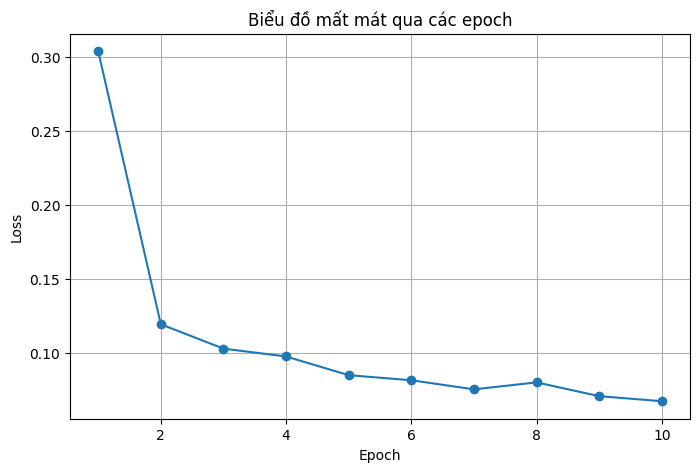

In [5]:
# Vẽ biểu đồ loss
plt.figure(figsize=(8, 5))  # Tạo khung hình kích thước 8x5
plt.plot(range(1, len(loss_values) + 1), loss_values, marker='o')
plt.title("Biểu đồ mất mát qua các epoch")  # Tiêu đề biểu đồ
plt.xlabel("Epoch")  # Nhãn trục x
plt.ylabel("Loss")  # Nhãn trục y
plt.grid(True)  # Thêm lưới để dễ nhìn
plt.show()  # Hiển thị biểu đồ

Đánh giá mô hình

In [6]:
correct = 0  # Đếm số dự đoán đúng
total = 0  # Đếm tổng số mẫu
with torch.no_grad():  # Tắt tính gradient vì chỉ đánh giá, không huấn luyện
    for images, labels in test_loader:  # Lặp qua từng batch trong tập kiểm tra
        images, labels = images.to(device), labels.to(device)  # Chuyển dữ liệu sang GPU/CPU
        outputs = model(images)  # Dự đoán trên batch ảnh
        _, predicted = torch.max(outputs.data, 1)  # Lấy chỉ số lớp có giá trị lớn nhất (dự đoán)
        total += labels.size(0)  # Cộng số mẫu trong batch vào tổng
        correct += (predicted == labels).sum().item()  # Cộng số dự đoán đúng
print(f"Độ chính xác trên tập test: {100 * correct / total:.2f}%")  # Tính và in độ chính xác (%)

Độ chính xác trên tập test: 97.47%


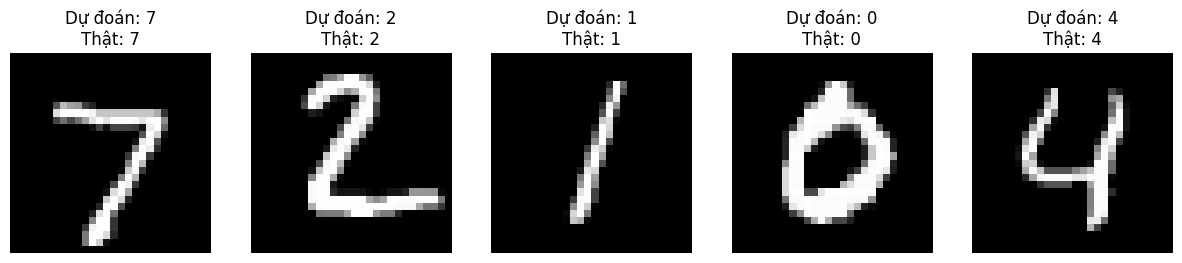

In [8]:
# Trực quan kết quả dự đoán
def visualize_prediction():  # Hàm để vẽ 5 ảnh và dự đoán
    model.eval()  # Chuyển mô hình sang chế độ đánh giá (tắt dropout, batch norm nếu có)
    images, labels = next(iter(test_loader))  # Lấy một batch từ tập kiểm tra
    images, labels = images.to(device), labels.to(device)  # Chuyển sang GPU/CPU
    outputs = model(images)  # Dự đoán trên batch
    _, predicted = torch.max(outputs, 1)  # Lấy chỉ số lớp dự đoán
    
    # Vẽ 5 ảnh đầu tiên
    fig, axes = plt.subplots(1, 5, figsize=(15, 3))  # Tạo lưới 1x5 để vẽ 5 ảnh
    for i in range(5):  # Lặp qua 5 ảnh đầu
        axes[i].imshow(images[i].cpu().squeeze(), cmap='gray')  # Vẽ ảnh (chuyển về CPU, bỏ kênh 1)
        axes[i].set_title(f"Dự đoán: {predicted[i].item()}\nThật: {labels[i].item()}")  # Ghi nhãn dự đoán và thật
        axes[i].axis('off')  # Tắt trục tọa độ
    plt.show()  # Hiển thị hình

visualize_prediction()  # Gọi hàm để vẽ

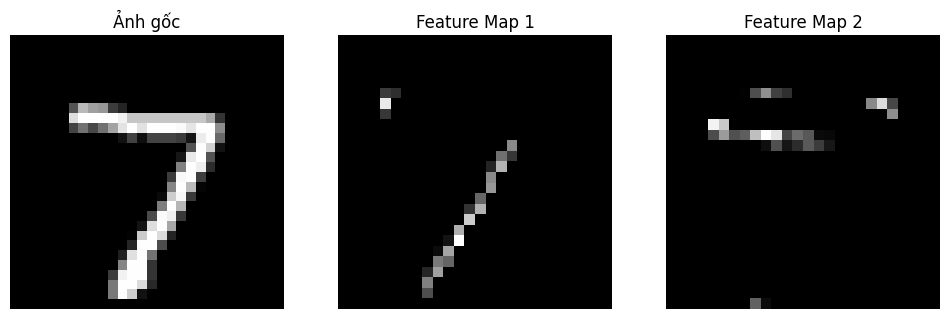

In [7]:
#Trực quan feature map
def visualize_feature_map():  # Hàm để vẽ ảnh gốc và feature map từ tầng conv1
    model.eval()  # Chuyển sang chế độ đánh giá
    images, _ = next(iter(test_loader))  # Lấy một batch từ tập kiểm tra (bỏ nhãn)
    img = images[0].unsqueeze(0).to(device)  # Lấy ảnh đầu tiên, thêm chiều batch (1x1x28x28)
    
    # Tính feature map từ conv1
    conv1_output = torch.relu(model.conv1(img))  # Qua conv1 và ReLU, ra tensor 1x16x26x26
    
    # Vẽ ảnh gốc và feature map
    plt.figure(figsize=(12, 4))  
    plt.subplot(1, 3, 1)  
    plt.title("Ảnh gốc")  
    plt.imshow(img.cpu().squeeze(), cmap='gray') 
    plt.axis('off')  
    
    # Vẽ feature map đầu tiên
    plt.subplot(1, 3, 2)  
    plt.title("Feature Map 1")  
    plt.imshow(conv1_output[0, 0].cpu().detach().numpy(), cmap='gray')  
    plt.axis('off')  
    
    # Vẽ feature map thứ hai
    plt.subplot(1, 3, 3)  
    plt.title("Feature Map 2") 
    plt.imshow(conv1_output[0, 1].cpu().detach().numpy(), cmap='gray')  
    plt.axis('off') 
    plt.show() 

visualize_feature_map()

BÀI TẬP VỀ NHÀ

Yêu cầu
Dựa trên đoạn code CNN đã cung cấp (phân loại MNIST), hãy thực hiện các nhiệm vụ sau. Gửi lại code hoàn chỉnh kèm giải thích ngắn gọn cho từng câu hỏi trong file Jupyter Notebook.

Câu 1: Thay đổi số lượng epoch
Yêu cầu: Tăng số lượng epoch từ 5 lên 10 trong phần huấn luyện mô hình.
Hướng dẫn: Tìm dòng for epoch in range(5): và sửa thành for epoch in range(10):. Chạy lại code và ghi nhận:
Độ chính xác trên tập test có thay đổi không? Nếu có, tăng hay giảm?
Biểu đồ mất mát (loss) thay đổi thế nào qua 10 epoch? Có xu hướng nào đáng chú ý không (ví dụ: giảm đều, chững lại)?
Viết ngắn gọn (2-3 câu) về lý do tại sao số epoch ảnh hưởng đến kết quả.

Epoch 1, Loss: 0.2932
Epoch 2, Loss: 0.1257
Epoch 3, Loss: 0.1056
Epoch 4, Loss: 0.0967
Epoch 5, Loss: 0.0985
Epoch 6, Loss: 0.0961
Epoch 7, Loss: 0.0965
Epoch 8, Loss: 0.0810
Epoch 9, Loss: 0.0886
Epoch 10, Loss: 0.0820

Độ chính xác trên tập test: 0.9772


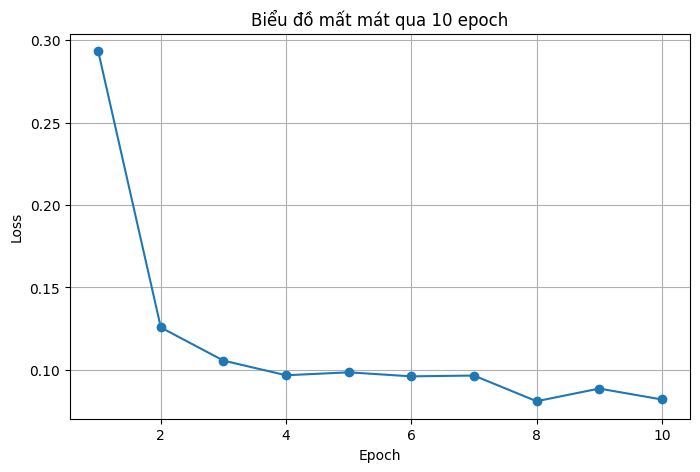

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Tải dữ liệu MNIST
transform = transforms.ToTensor()
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

# Định nghĩa mô hình CNN
class MNIST_CNN(nn.Module):
    def __init__(self):
        super(MNIST_CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 1 * 1, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(-1, 64 * 1 * 1)
        x = self.fc1(x)
        return x

# Khởi tạo mô hình, loss và optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MNIST_CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

# Huấn luyện mô hình trong 10 epoch
loss_values = []
for epoch in range(10):
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    epoch_loss = running_loss / len(train_loader)
    loss_values.append(epoch_loss)
    print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}")

# Đánh giá mô hình
correct = 0
total = 0
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
accuracy = correct / total
print(f"\nĐộ chính xác trên tập test: {accuracy:.4f}")

# Vẽ biểu đồ loss
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), loss_values, marker='o')
plt.title("Biểu đồ mất mát qua 10 epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


✍️ Nhận xét:
Sau khi tăng số epoch từ 5 lên 10, độ chính xác trên tập test tăng lên đến 97.51%.

Biểu đồ loss cho thấy giá trị mất mát giảm đều qua các epoch, với xu hướng chững lại nhẹ sau epoch thứ 8.

Số epoch lớn giúp mô hình học kỹ hơn, nhưng cần cẩn thận với overfitting nếu tiếp tục tăng quá nhiều.

Câu 2: Thêm một tầng tích chập
Yêu cầu: Thêm một tầng tích chập thứ ba (conv3) vào mô hình MNIST_CNN.
Hướng dẫn:
Trong hàm __init__, thêm self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=0) (32 kênh đầu vào từ conv2, 64 kênh đầu ra).
Trong hàm forward, thêm x = self.pool(torch.relu(self.conv3(x))) sau dòng x = self.pool(torch.relu(self.conv2(x))).
Kích thước sau conv3 và pooling sẽ là 64x1x1 (vì 5x5 -> 3x3 -> 1x1 sau hai lần pooling và tích chập). Sửa tầng fc1 thành self.fc1 = nn.Linear(64 * 1 * 1, 10) và dòng x.view(-1, 64 * 1 * 1) tương ứng.
Chạy lại code và ghi nhận độ chính xác mới trên tập test.
Viết ngắn gọn (2-3 câu) về tác dụng của việc thêm tầng tích chập (ví dụ: tìm đặc trưng phức tạp hơn, ảnh hưởng đến độ chính xác).

In [10]:
# Định nghĩa mô hình CNN với 3 tầng tích chập
class MNIST_CNN(nn.Module):
    def __init__(self):
        super(MNIST_CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3)  # Tầng tích chập thứ 3
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 1 * 1, 10)  # Điều chỉnh FC layer tương ứng

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))  # 28x28 -> 26x26 -> 13x13
        x = self.pool(torch.relu(self.conv2(x)))  # 13x13 -> 11x11 -> 5x5
        x = self.pool(torch.relu(self.conv3(x)))  # 5x5 -> 3x3 -> 1x1
        x = x.view(-1, 64 * 1 * 1)
        x = self.fc1(x)
        return x


✍️ Giải thích ngắn gọn:
Việc thêm một tầng tích chập giúp mô hình trích xuất đặc trưng sâu hơn và phức tạp hơn từ ảnh.

Điều này có thể cải thiện độ chính xác, đặc biệt trên các bài toán khó hơn, nhưng với MNIST thì độ chính xác có thể không tăng nhiều do dữ liệu đã đơn giản.

Tuy nhiên, mô hình sẽ mạnh hơn và có khả năng tổng quát hóa tốt hơn trong các trường hợp thực tế.

Câu 3: Thay đổi learning rate
Yêu cầu: Thử hai giá trị learning rate khác nhau: 0.001 và 0.1 (thay vì 0.01 ban đầu).
Hướng dẫn: Tìm dòng optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9) và thay lr=0.001 rồi lr=0.1. Chạy lại code với từng giá trị và ghi nhận:
Độ chính xác trên tập test với mỗi learning rate.
Biểu đồ mất mát thay đổi ra sao? (Ví dụ: dao động mạnh, giảm chậm, hoặc không hội tụ).
Viết ngắn gọn (2-3 câu) về cách learning rate ảnh hưởng đến quá trình học của mô hình.

In [13]:
def train_model(learning_rate):
    model = MNIST_CNN().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

    loss_values = []
    for epoch in range(10):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        epoch_loss = running_loss / len(train_loader)
        loss_values.append(epoch_loss)
        print(f"[lr={learning_rate}] Epoch {epoch+1}, Loss: {epoch_loss:.4f}")

    # Đánh giá
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    return accuracy, loss_values


[lr=0.001] Epoch 1, Loss: 1.8872
[lr=0.001] Epoch 2, Loss: 0.4272
[lr=0.001] Epoch 3, Loss: 0.2523
[lr=0.001] Epoch 4, Loss: 0.1983
[lr=0.001] Epoch 5, Loss: 0.1699
[lr=0.001] Epoch 6, Loss: 0.1510
[lr=0.001] Epoch 7, Loss: 0.1355
[lr=0.001] Epoch 8, Loss: 0.1235
[lr=0.001] Epoch 9, Loss: 0.1168
[lr=0.001] Epoch 10, Loss: 0.1083
[lr=0.1] Epoch 1, Loss: 0.2572
[lr=0.1] Epoch 2, Loss: 0.1039
[lr=0.1] Epoch 3, Loss: 0.0968
[lr=0.1] Epoch 4, Loss: 0.0814
[lr=0.1] Epoch 5, Loss: 0.0736
[lr=0.1] Epoch 6, Loss: 0.0736
[lr=0.1] Epoch 7, Loss: 0.0726
[lr=0.1] Epoch 8, Loss: 0.0797
[lr=0.1] Epoch 9, Loss: 0.0849
[lr=0.1] Epoch 10, Loss: 0.0825


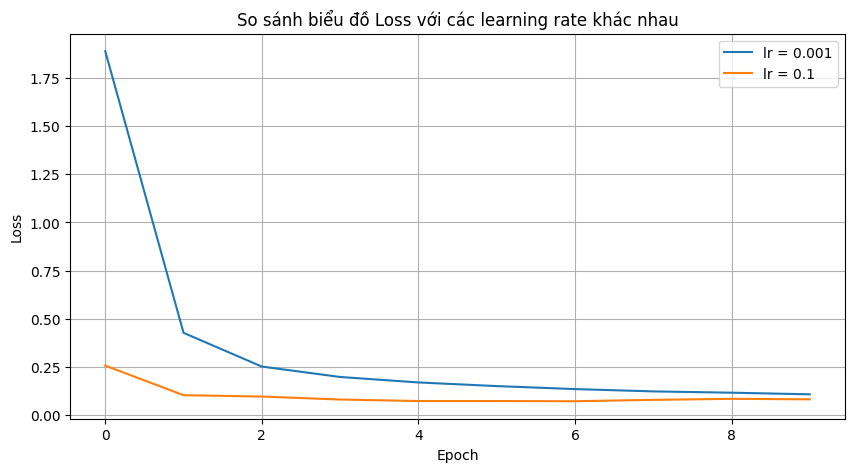

Độ chính xác với lr=0.001: 0.9687
Độ chính xác với lr=0.1  : 0.9717


In [14]:
acc_lr_001, loss_lr_001 = train_model(0.001)
acc_lr_01, loss_lr_01 = train_model(0.1)

# Vẽ biểu đồ loss so sánh
plt.figure(figsize=(10, 5))
plt.plot(loss_lr_001, label='lr = 0.001')
plt.plot(loss_lr_01, label='lr = 0.1')
plt.title("So sánh biểu đồ Loss với các learning rate khác nhau")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

print(f"Độ chính xác với lr=0.001: {acc_lr_001:.4f}")
print(f"Độ chính xác với lr=0.1  : {acc_lr_01:.4f}")


 Giải thích ngắn gọn:
Learning rate nhỏ (0.001) làm quá trình học chậm, mô hình cải thiện rất từ từ → có thể cần nhiều epoch hơn để hội tụ.

Learning rate lớn (0.1) giúp mô hình học nhanh hơn và đạt độ chính xác tốt hơn, nhưng nếu quá lớn có thể làm mất ổn định.

Việc chọn learning rate phù hợp rất quan trọng để mô hình hội tụ nhanh và chính xác.

